Intention of this notebook ist to use the best architecture as determined through hypertuning and train it on the most data possible to and save it to use it for feature extraction later on. (basically like the *train+* model)

I also created a slightly different model architectures to the best one to campare differently sized feature extractions (not in thesis, turned out to be futile, especially since last layer doesnt contain any useful information apperently).

Thein feature extraction/tranfer learning is done on protein sequences in the *Merck&Co+* dataset.

## Set up notebook and environment: 

### Connect to google drive: ###

In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras #where?
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.image as mpimg
from keras.utils import plot_model
from sklearn import preprocessing
import gc
from sklearn.model_selection import KFold

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Specify location of all relevant data: (YOU HAVE TO INSERT YOUR FILE LOCATIONS) ###

In [0]:
print("Check correctnes of locations: ")
data_folder_location = "gdrive/My Drive/iGEM/Databases/BacDive/Data/"
model_saves_folder_location = "gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Transfer_Learning/"
data_filter_location = data_folder_location+"merck_and_co_dup_aa_concat_filter.npy"
X_location = data_folder_location+"X.npy"
y_location = data_folder_location+"y_growth_avg.npy"
print(os.path.isdir(data_folder_location))
print(os.path.isdir(model_saves_folder_location))
print(os.path.isfile(data_filter_location))
print(os.path.isfile(X_location))
print(os.path.isfile(y_location))

Check correctnes of locations: 
True
True
True
True
True


### Function to easily retrieve cleaned data with split either from drive or cache, depending wheter data was already retrieved using this function ###

In [0]:
def retrieve_data(X_loc, y_loc, test_split=0.2, random_state=42):
  if not(os.path.isfile("X_train_H.npy")):
    #Load data from drive
    print("Loading data from drive...")
    X_load = np.load(X_loc)
    y_load = np.load(y_loc)
    filter_load = np.load(data_filter_location)
    
    #Apply pre filter
    X_load = X_load[filter_load]
    y_load = y_load[filter_load]
    gc.collect()
    
    #Remove all entries that have no temperature information #can happen, since for some organism specific temperature information is not available
    temp_label_filter = np.logical_not(np.isnan(y_load))
    X_load = X_load[temp_label_filter]
    y_load = y_load[temp_label_filter]
    gc.collect()
    
    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_load, y_load, test_size=test_split, random_state=random_state) 
    
    #Cache data
    print("Caching data...")
    np.save('X_train_H.npy', X_train)   
    np.save('X_test_H.npy', X_test)   
    np.save('y_train_H.npy', y_train)   
    np.save('y_test_H.npy', y_test) 
    
    return X_train, X_test, y_train, y_test
  else:
    print("Loading data from cache...")
    return np.load('X_train_H.npy'), np.load('X_test_H.npy'), np.load('y_train_H.npy'), np.load('y_test_H.npy') 

In [0]:
X_train, X_test, y_train, y_test = retrieve_data(X_location,y_location)
gc.collect()

Loading data from drive...
Caching data...


10

### Prepare target label

In [0]:
standard_scaler = preprocessing.StandardScaler()
y_train_scaled = standard_scaler.fit_transform(y_train.reshape(-1, 1)).reshape((len(y_train))) #only fit on y_train to prevent information leakage

#Upon review: this actually doesnt make sence; should have used the standard_scaler to scale this: impacts training performance, however, evaluation metrics still valid
standard_scaler_test = preprocessing.StandardScaler()
y_test_scaled= standard_scaler_test.fit_transform(y_test.reshape(-1, 1)).reshape((len(y_test))) #scale y_test seperately

In [0]:
print(X_train.shape)
print(y_train_scaled.shape)
print(X_test.shape)
print(y_test_scaled.shape)

(6149359, 650)
(6149359,)
(1537340, 650)
(1537340,)


In [0]:
y_offset = len(y_test)%8 #needed because of 8 tpu cores, only for validation?
print(y_offset)

4


## Supplementary functions

In [0]:
def train_on_TPU_regression(model,model_save_loc, X_train, y_train, X_test, y_test, batch_size=1024, epochs=25, save_best_only=True, period=1, train_patience=3, mse=True, weight_loc=None):
  print("Batch size: {} (this corresponds to {} on GPUs)".format(batch_size,batch_size//8))
  print("Optimization criterion MSE: ", str(mse))
  print("Epochs: ", epochs)
  print("Patience: ", train_patience)
  print("Period: ", period)
  print("Save best only: ",save_best_only)
  print("Model save location: ",model_save_loc)
  print("\n")
  
  #Identify TPU worker
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.logging.set_verbosity(tf.logging.INFO)
  
  #Useful to avoid clutter from old models / layers.
  tf.keras.backend.clear_session()

  #Convert model to TPU model
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
  
  print("\n")

  #Compile the model
  if mse:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(),
      loss=tf.keras.losses.mean_squared_error,
      metrics=['mse']
    )
  else:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(), 
      loss=tf.keras.losses.mean_absolute_error,
      metrics=['mae']
    )
    
  if not(weight_loc is None):
    tpu_model.load_weights(weight_loc)
  
  #Configure how to save model and early stopping
  callbacks_list = [
      tf.keras.callbacks.ModelCheckpoint(
          filepath=model_save_loc,
          save_weights_only=True,
          monitor='val_loss', 
          save_best_only=save_best_only,
          mode='auto',
          period=period),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                       patience=train_patience, #more than 3 doesnt help (except when using generator), since the TPU runs out ouf memory for some reason???
                                       mode='auto')
  ]
  
  history = tpu_model.fit(X_train,
                          y_train,
                          validation_data=(X_test,y_test),
                          epochs=epochs,
                          batch_size=batch_size,
                          callbacks=callbacks_list,
                          verbose=1)

  return tpu_model, history

In [0]:
def calc_reg_pred(model, weight_loc, X_test, y_test, batch_size=1024, mse=True, scaler=None):
  print("TPU worker setup:")
  #Identify TPU worker
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.logging.set_verbosity(tf.logging.INFO)
  
  #Useful to avoid clutter from old models / layers.
  tf.keras.backend.clear_session()
  
  #Convert model to TPU model
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
  
  print("\n")
  
  #Compile the model #doesnt really matter which loss function here
  if mse:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(), 
      loss=tf.keras.losses.mean_squared_error,
      metrics=['mse']
    )
  else:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(),
      loss=tf.keras.losses.mean_absolute_error,
      metrics=['mae']
    )
  
  tpu_model.load_weights(weight_loc)
  
  print("Calculating predictions:")
  y_pred = tpu_model.predict(X_test, batch_size=1024, verbose=1)

  if not(scaler is None):
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    
  rmse_err = np.sqrt(mean_squared_error(y_test, y_pred)) 
  mae_err = mean_absolute_error(y_test, y_pred)
  
  return y_pred, rmse_err, mae_err

In [0]:
def plt_model(model,figure_size=(25,25)):
  plt.figure(figsize=figure_size, dpi=300)
  plot_model(model, to_file='model.png')
  plt.imshow(mpimg.imread('model.png'))
  plt.show()

In [0]:
def plt_history(history):
  #history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

## Define, Train and Test Models 


In [0]:
SEQUENCE_LEN = 650
CLASSES = 21 #now that sequences with non cannonical AAs removed there are 20 left and "0" encoding "None"

### Model default //MAE: 5.454390259456975, RMSE:  8.090829165558414 
//Just a copy from hypertuning best eval

In [0]:
#model name:
model_name = "default"
model_save_loc = model_saves_folder_location+"model_transfer_learning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x_mid)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid = tf.keras.layers.GlobalMaxPooling1D()(x_mid)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x], axis=-1)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 8)       168         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 322, 256)     14592       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 322, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 322, 256)     0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 320, 256)     196864      activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 320, 256)     1024        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256)     0           batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 318, 256)     196864      activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_2 (Batch (None, 318, 256)     1024        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 318, 256)     0           batch_normalization_v1_2[0][0]   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 106, 256)     0           activation_2[0][0]               
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 104, 512)     393728      max_pooling1d[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_3 (Batch (None, 104, 512)     2048        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 104, 512)     0           batch_normalization_v1_3[0][0]   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 102, 512)     786944      activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 102, 512)     2048        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 102, 512)     0           batch_normalization_v1_4[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 512)     786944      activation_4[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_5 (Batch (None, 100, 512)     2048        conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 100, 512)     0           batch_normalization_v1_5[0][0]   
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           activation_2[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           activation_5[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 768)          0           global_max_pooling1d[0][0]       
                                                                 global_max_pooling1d_1[0][0]     
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          393728      concatenate[0][0]                
__________________________________________________________________________________________________
batch_normalization_v1_6 (Batch (None, 512)          2048        dense[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 512)          0           batch_normalization_v1_6[0][0]   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      activation_6[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 512)          2048        dense_1[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 512)          0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            513         activation_7[0][0]               
==================================================================================================
Total params: 3,046,313
Trainable params: 3,039,657
Non-trainable params: 6,656
__________________________________________________________________________________________________
```



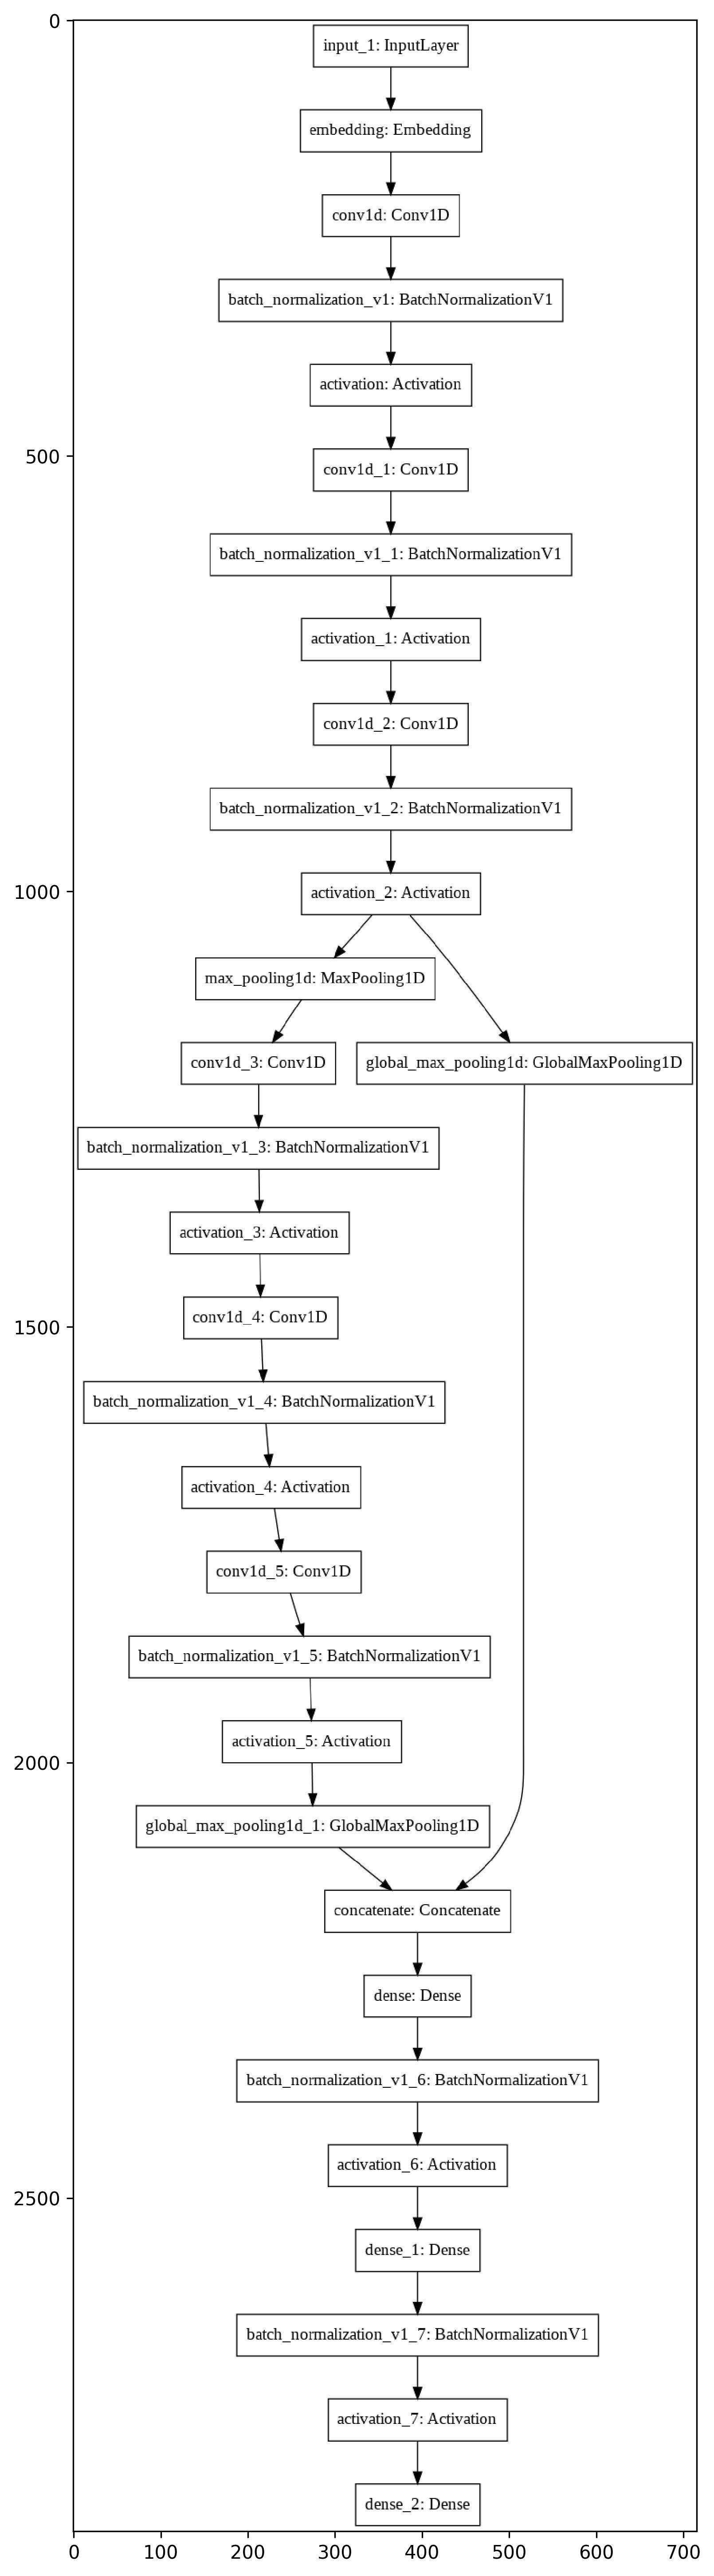

In [0]:
plt_model(model,(25,25))

In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train, y_train_scaled, X_test[:-y_offset], y_test_scaled[:-y_offset], batch_size=512, train_patience=5)



```
Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  5
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Best_Eval/model_hypertuning_advanced_split_train_test.hdf5



WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.24.215.218:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3276306124262609034)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9166767952360190517)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 18402037925273512696)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1987843552644180490)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 442682524076814578)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 9692330405279940157)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 12468288559044583141)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 12634614901219677262)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 15913730728519673584)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 5536081206282554172)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 528947077617645415)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 6149359 samples, validate on 1537336 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/tpu/python/tpu/keras_support.py:302: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.270069599151611 secs
INFO:tensorflow:Setting weights on TPU model.
6148608/6149359 [============================>.] - ETA: 0s - loss: 0.6245 - mean_squared_error: 0.6245INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(29,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(29, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(29, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.475467205047607 secs
6149120/6149359 [============================>.] - ETA: 0s - loss: 0.6245 - mean_squared_error: 0.6245INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.154740571975708 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(39,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(39, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(39, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.313333511352539 secs
INFO:tensorflow:Copying TPU weights to the CPU
6149359/6149359 [==============================] - 1133s 184us/sample - loss: 0.6245 - mean_squared_error: 0.6245 - val_loss: 0.5748 - val_mean_squared_error: 0.5748
Epoch 2/25
6149120/6149359 [============================>.] - ETA: 0s - loss: 0.5202 - mean_squared_error: 0.5202INFO:tensorflow:Copying TPU weights to the CPU
6149359/6149359 [==============================] - 1089s 177us/sample - loss: 0.5202 - mean_squared_error: 0.5202 - val_loss: 0.5192 - val_mean_squared_error: 0.5192
Epoch 3/25
6149120/6149359 [============================>.] - ETA: 0s - loss: 0.4686 - mean_squared_error: 0.4686INFO:tensorflow:Copying TPU weights to the CPU
6149359/6149359 [==============================] - 1095s 178us/sample - loss: 0.4686 - mean_squared_error: 0.4686 - val_loss: 0.5122 - val_mean_squared_error: 0.5122
Epoch 4/25
6149120/6149359 [============================>.] - ETA: 0s - loss: 0.4320 - mean_squared_error: 0.4320INFO:tensorflow:Copying TPU weights to the CPU
6149359/6149359 [==============================] - 1096s 178us/sample - loss: 0.4320 - mean_squared_error: 0.4320 - val_loss: 0.4949 - val_mean_squared_error: 0.4949
Epoch 5/25
3416064/6149359 [===============>..............] - ETA: 7:46 - loss: 0.4024 - mean_squared_error: 0.4024Buffered data was truncated after reaching the output size limit.
```



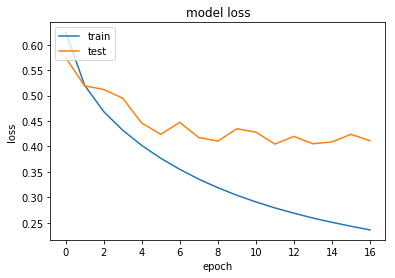

In [0]:
#history for loss
plt_history(history)

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test[:-y_offset], y_test[:-y_offset], scaler=standard_scaler)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.454390259456975
Root mean squared error:  8.090829165558414
```



### Model default 64 //MAE: 5.276642688673102, RMSE:  7.925958157831267 (not in thesis)

In [0]:
#model name:
model_name = "default_64"
model_save_loc = model_saves_folder_location+"model_transfer_learning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x_mid)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid = tf.keras.layers.GlobalMaxPooling1D()(x_mid)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x], axis=-1)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 8)       168         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 322, 256)     14592       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 322, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 322, 256)     0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 320, 256)     196864      activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 320, 256)     1024        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256)     0           batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 318, 256)     196864      activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_2 (Batch (None, 318, 256)     1024        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 318, 256)     0           batch_normalization_v1_2[0][0]   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 106, 256)     0           activation_2[0][0]               
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 104, 512)     393728      max_pooling1d[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_3 (Batch (None, 104, 512)     2048        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 104, 512)     0           batch_normalization_v1_3[0][0]   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 102, 512)     786944      activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 102, 512)     2048        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 102, 512)     0           batch_normalization_v1_4[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 512)     786944      activation_4[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_5 (Batch (None, 100, 512)     2048        conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 100, 512)     0           batch_normalization_v1_5[0][0]   
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           activation_2[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           activation_5[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 768)          0           global_max_pooling1d[0][0]       
                                                                 global_max_pooling1d_1[0][0]     
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          393728      concatenate[0][0]                
__________________________________________________________________________________________________
batch_normalization_v1_6 (Batch (None, 512)          2048        dense[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 512)          0           batch_normalization_v1_6[0][0]   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      activation_6[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 512)          2048        dense_1[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 512)          0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           32832       activation_7[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_8 (Batch (None, 64)           256         dense_2[0][0]                    
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 64)           0           batch_normalization_v1_8[0][0]   
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1)            65          activation_8[0][0]               
==================================================================================================
Total params: 3,078,953
Trainable params: 3,072,169
Non-trainable params: 6,784
__________________________________________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train, y_train_scaled, X_test[:-y_offset], y_test_scaled[:-y_offset], batch_size=512, train_patience=5)



```
Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  5
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Transfer_Learning/model_transfer_learning_default_64.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.7.18.170:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 7396103254533080747)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 2343493391697282080)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 13139438492095079455)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 10775135542184530426)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 15302006074672068625)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 10549098638032263161)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 6395436771773105066)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 257849790721302567)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 5705177580306866143)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 1276886532923825736)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 6381523992078894733)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 6149359 samples, validate on 1537336 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_3_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 8.54957127571106 secs
INFO:tensorflow:Setting weights on TPU model.
6148608/6149359 [============================>.] - ETA: 0s - loss: 0.6148 - mean_squared_error: 0.6148INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(29,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(29, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(29, 1), dtype=tf.float32, name='dense_3_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.4049787521362305 secs
6149120/6149359 [============================>.] - ETA: 0s - loss: 0.6147 - mean_squared_error: 0.6147INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_3_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.751040935516357 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(39,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(39, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(39, 1), dtype=tf.float32, name='dense_3_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.143362760543823 secs
INFO:tensorflow:Copying TPU weights to the CPU
6149359/6149359 [==============================] - 1147s 186us/sample - loss: 0.6147 - mean_squared_error: 0.6147 - val_loss: 0.7198 - val_mean_squared_error: 0.7198
Epoch 2/25
6149120/6149359 [============================>.] - ETA: 0s - loss: 0.5178 - mean_squared_error: 0.5178INFO:tensorflow:Copying TPU weights to the CPU
6149359/6149359 [==============================] - 1098s 178us/sample - loss: 0.5178 - mean_squared_error: 0.5178 - val_loss: 0.5170 - val_mean_squared_error: 0.5170
Epoch 3/25
6149120/6149359 [============================>.] - ETA: 0s - loss: 0.4684 - mean_squared_error: 0.4684INFO:tensorflow:Copying TPU weights to the CPU
6149359/6149359 [==============================] - 1099s 179us/sample - loss: 0.4684 - mean_squared_error: 0.4684 - val_loss: 0.4910 - val_mean_squared_error: 0.4910
Epoch 4/25
6149120/6149359 [============================>.] - ETA: 0s - loss: 0.4331 - mean_squared_error: 0.4331INFO:tensorflow:Copying TPU weights to the CPU
6149359/6149359 [==============================] - 1089s 177us/sample - loss: 0.4331 - mean_squared_error: 0.4331 - val_loss: 0.4736 - val_mean_squared_error: 0.4736
Epoch 5/25
3431936/6149359 [===============>..............] - ETA: 7:36 - loss: 0.4048 - mean_squared_error: 0.4048Buffered data was truncated after reaching the output size limit.
```



In [0]:
#history for loss
plt_history(history)

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test[:-y_offset], y_test[:-y_offset], scaler=standard_scaler)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.276642688673102
Root mean squared error:  7.925958157831267
```

